This produces plots showing the operation of the resampling process.
It uses only 15 particles and plots the prior distribution of each particle
and the full prior averaged/normalised over all particles.
The first plot also shows the likelihood of an observation at 500.

The second plot shows the posterior obtained by multiplying the full prior and the likelihood, and
both the new (resampled) particles and the unchanged particles, and the new full prior.
3 of the 15 particles are updated.

Third plot repeats the process with a new observation


It was derived from the notebook plotting the evolution of the prior and the effect of repeating observations.
It would probably have been better to have started again.

Note that the scales of the particle priors and the full prior are different, but they aren't really comparable anyway.

The rng is seeded
np.random.seed(976)
to ensure that the code always produces the same plot every time it is run.
The seed was chosen so that the lines in the plots don't fall on top of each other
and you can clearly see the location of the resampled particles.

The initial location of the particles is evenly spaced with a bit of random jitter.

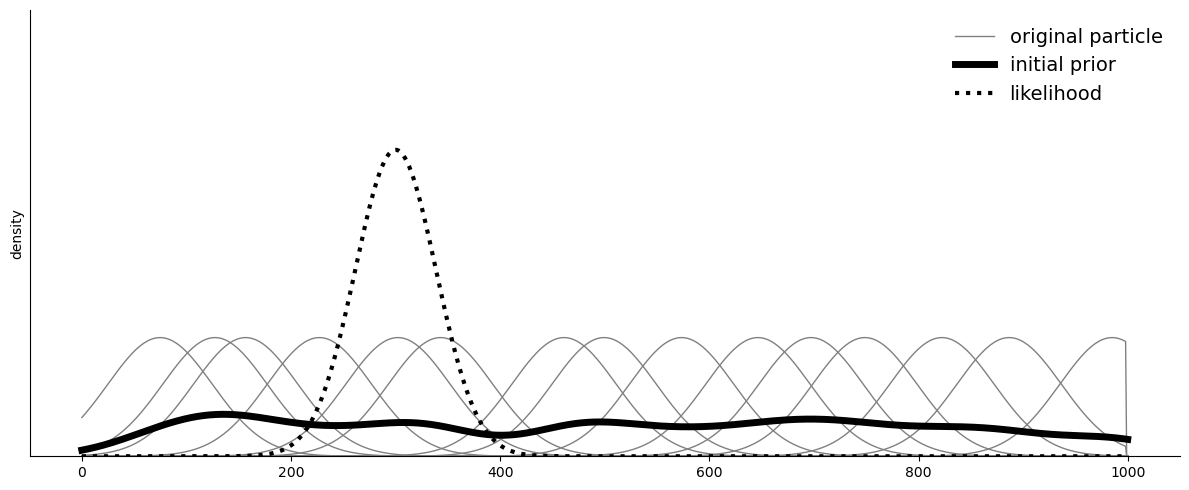

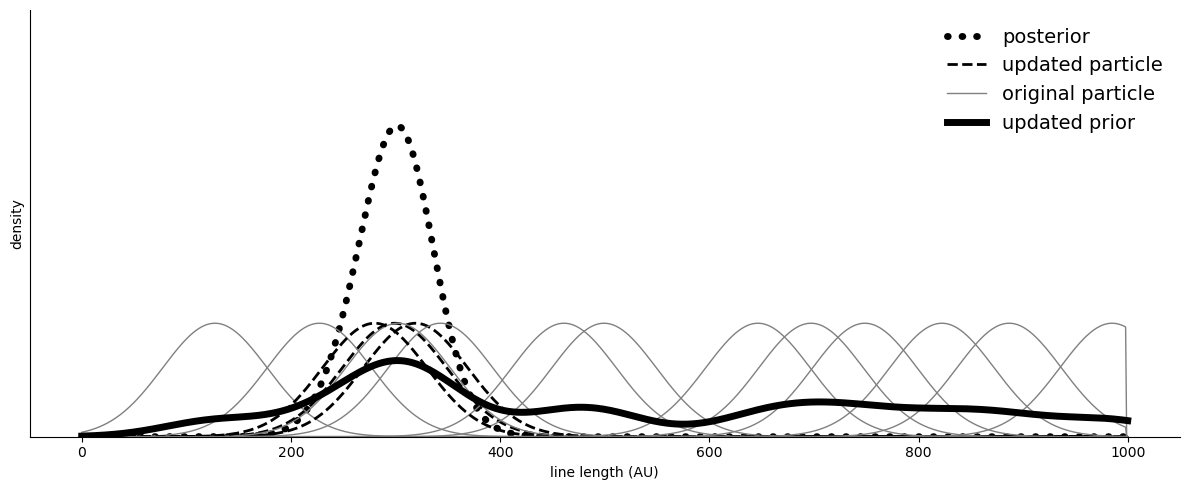

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
particle_variance = 2500.0 
observation_variance = 1500.0 
obs = 300
num_particles = 15 
num_resample = 3  
line_length_points = np.arange(1001) # range of 'line_lengths'
num_runs = 1 # iterations. Use 1000 for stable results

#obs_value = obs
#observations = [obs_value] # the observation - was a sequenece of observcations
                     # but here we're just using one trial
plot_steps = np.array([1])  # Plot only after these observation indexes (1-based)
                            # now we're only plotting at the end

y_max = 0.01 # hardwired to cope with both plots
              # sets both the range of the plot and y_ticks
x_limit_for_plots = 1000
# plot dimensions in inches
plt.figure(figsize=(12, 5))

# set the seed so that the figure is reproducable
# chosen so that the lines in the plots don't fall on top of each other.
np.random.seed(971)




def gaussian(x, mean, variance):
    return norm.pdf(x, mean, np.sqrt(variance))

def compute_prior(particles, variance, line_length_points, replace_indexes, particle_label, make_plot=False):
    done_prior_label = False
    done_replaced_label = False
    
    prior = np.zeros_like(line_length_points, dtype=float)
    std = np.sqrt(variance)
    # centre is values not indexes
    for part_index, centre in enumerate(particles):
        local_min = int(max(0, np.ceil(centre - 4 * std)))
        local_max = int(min(1000, np.floor(centre + 4 * std)))
        x_vals = np.arange(local_min, local_max + 1)
        g_vals = gaussian(x_vals, centre, variance)
        prior[x_vals] += g_vals
        
        one_particle_prior = np.zeros_like(line_length_points, dtype=float)
        #print(local_min, local_max, local_max- local_min, len(tmp), len(g_vals))
        if make_plot:   
            # construct array for each prior
            for i in range(local_min, local_max -1, 1):
                one_particle_prior[i] += g_vals[i - local_min]
                
            # reduce the one_particle_prior to make it easier to distinguish this from other curves
            one_particle_prior *= 0.5
          
            # this lot ensures that there is just one legend for each of the replaced and fixed plots
            if part_index in replace_indexes:
                if not done_replaced_label:
                    plt.plot(line_length_points, one_particle_prior, color='black', label='updated particle', linewidth=2, linestyle='dashed')
                    done_replaced_label = True
                else:
                    plt.plot(line_length_points, one_particle_prior, color='black',  linewidth=2, linestyle='dashed')
            else:
                if not done_prior_label:
                    plt.plot(line_length_points, one_particle_prior, color='grey', label= particle_label, linewidth=1, linestyle='solid')
                    done_prior_label = True
                else:
                    plt.plot(line_length_points, one_particle_prior, color='grey', linewidth=1, linestyle='solid')
                
    return prior / np.sum(prior)


def apply_observation(particles, obs_value, line_length_points, particle_variance, observation_variance):
    dummy_replace_indexes = [-1]
    prior = compute_prior(particles, particle_variance, line_length_points, dummy_replace_indexes, 'previous particle', make_plot=False)
    likelihood = gaussian(line_length_points, mean=obs_value, variance=observation_variance)
    likelihood /= np.sum(likelihood)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)

    # do the update/resampling
    resampled = np.random.choice(line_length_points, size=num_resample, replace=True, p=posterior)
    replace_indexes = np.random.choice(len(particles), size=num_resample, replace=False)
    new_particles = particles.copy()
    new_particles[replace_indexes] = resampled
    return new_particles, likelihood, prior, posterior, replace_indexes



# construct the likelihood distribution here because we're now adding it to the first plot.
# This is a bit of a mess as we do it again later in apply_observation
likelihood = gaussian(line_length_points, obs_value, observation_variance)
likelihood /= np.sum(likelihood)

plt.rc('legend',fontsize=14) # set legend font size
plt.ylim(0, 0.015)


ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# do initial prior. 'Randomly' positioned particles
# particles = np.random.choice(line_length_points, size=num_particles, replace=False)

# Now we'll make the particles evenly spaced, with a bit of noise
# If we position the particles completely randomly there's a good chance that we'll
# get a lumpy prior that will mask the effects of the stimuli,
particles = np.linspace(50, 950, num_particles)
particles = np.random.normal(particles, 20.0)

# compute_prior plots the priors from the individual particles
replace_indexes = [-1]
avg_prior = compute_prior(particles, particle_variance, line_length_points, replace_indexes, 'original particle',  make_plot=True)
# plot overall prior
plt.plot(line_length_points, avg_prior,  label='initial prior', color='black', linewidth=5)

# whoops - we've not got a likelihood anymore!




plt.plot(line_length_points, likelihood, label='likelihood', color='black', linestyle='dotted', linewidth=3)
plt.legend(frameon=False)
plt.grid(False)
plt.yticks([]) 
# plt.xlabel('line length (AU)')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('Figure3_1D_resampling_A.png')
plt.show()

plt.figure(figsize=(12, 5))
# Run the simulation and average priors
particles, likelihood, prior, posterior, replace_indexes = apply_observation(particles, obs, line_length_points, particle_variance, observation_variance)
plt.plot(line_length_points, posterior, label='posterior', color='black',  linewidth=5, linestyle = (0,(0.1,2)),
    dash_capstyle = 'round')
avg_prior = compute_prior(particles, particle_variance, line_length_points, replace_indexes, 'original particle', make_plot=True)

ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 0.015)

plt.plot(line_length_points, avg_prior, label='updated prior', color='black',  linewidth=5)
# plt.plot(line_length_points, posterior, label='posterior', color='black', linestyle='dotted', linewidth=5)


plt.yticks([]) 
# plt.xlabel('line length (AU)')
plt.ylabel('density')
plt.grid(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Figure3_1D_resampling_B.png',  dpi = 500, bbox_inches='tight')
plt.show()



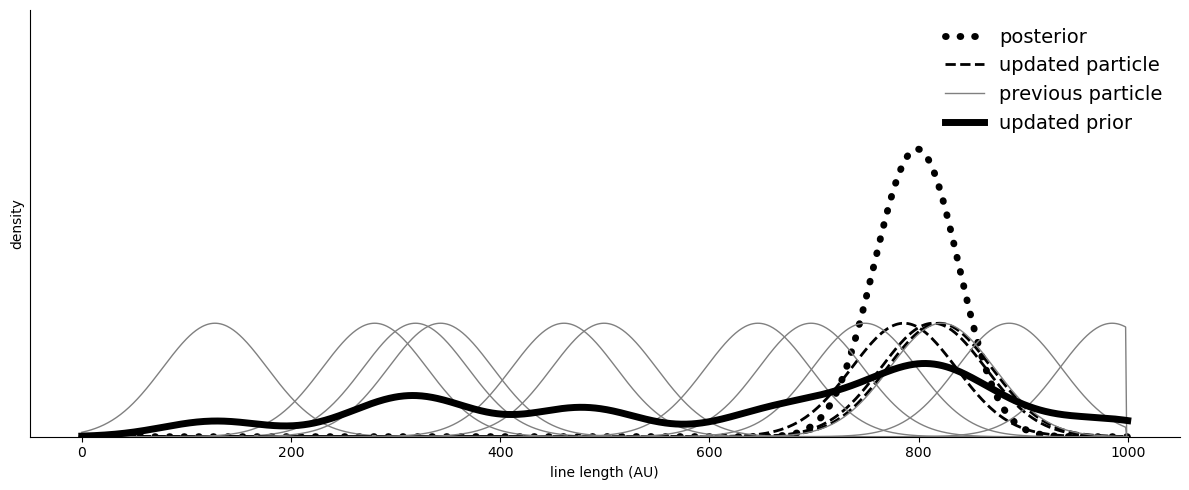

In [71]:
#obs_value = 300
obs = 800
#observations = [obs_value]
plt.figure(figsize=(12, 5))
particles, likelihood, prior, posterior, replace_indexes = apply_observation(particles, obs, line_length_points, particle_variance, observation_variance)
plt.plot(line_length_points, posterior, label='posterior', color='black',  linewidth=5, linestyle = (0,(0.1,2)),
    dash_capstyle = 'round')
avg_prior = compute_prior(particles, particle_variance, line_length_points, replace_indexes, 'previous particle', make_plot=True)

ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim(0, 0.015)
plt.plot(line_length_points, avg_prior, label='updated prior', color='black',  linewidth=5)
# plt.plot(line_length_points, posterior, label='posterior', color='black', linestyle='dotted', linewidth=5)


plt.yticks([]) 
plt.xlabel('line length (AU)')
plt.ylabel('density')
plt.grid(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('Figure3_1D_resampling_C.png',  dpi = 500, bbox_inches='tight')
plt.show()